In [80]:
import os
from glob import glob
from datetime import datetime
from collections import namedtuple
from pickle import dump, load

import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, precision_score , recall_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import transformers
from transformers import AutoModel, AutoConfig, AutoModelForSequenceClassification, AutoTokenizer, BertTokenizer, EarlyStoppingCallback, BatchEncoding
from transformers.data.processors import SingleSentenceClassificationProcessor
from transformers import Trainer, TrainingArguments
from transformers.integrations import TensorBoardCallback
from transformers.trainer_utils import EvaluationStrategy
from transformers.data.processors.utils import InputFeatures
import optuna 

from arabert.preprocess import ArabertPreprocessor

# Parameters

In [2]:
# Config
device = torch.device("cuda")

# Data params
validation_size = 4096

# Model params
model_name = "aubmindlab/bert-base-arabertv2"
model = AutoModel.from_pretrained(model_name)
for param in model.parameters():
    param.requires_grad = False
    
# Preprocessing params
sequence_length = 128
arabert_prep = ArabertPreprocessor(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Etc
model_string = f"./models/{str(datetime.today().date())}-train"
dataset_string = "{}_dataset-seqlen" + str(sequence_length)

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv2 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[2021-09-30 10:02:21,082 - farasapy_logger - WARNING]: Be careful with large lines as they may break on intera

# Functions

In [3]:
def get_SMADC_folder_data():
    """Returns a dataframe with Text and Region columns. Requires tree like this data/SMADC/*.txt"""
    files = glob("data/SMADC/*.txt")
    dataframes = []

    for file in files:
        region = file[-7:-4]
        temp_df = pd.read_csv(file, encoding="utf8", delimiter="\n", names=["Text"])
        temp_df["Region"] = region
        dataframes.append(temp_df)
        
    return pd.concat(dataframes)


def get_music_df():
    files = ["GLF","LEV","NOR","IRQ"]
    dataframes = []
    
    for file in files:
        temp_df = pd.read_csv(f'../extra_data/d7_data/{file}.txt', encoding="utf8", delimiter="\n", names=["Text"])
        temp_df["Region"] = file
        dataframes.append(temp_df)
    
    return pd.concat(dataframes)


def tokenize(batch):
    """
    Tokenizes a list of strings
    """
    return tokenizer.batch_encode_plus(
        batch,
        add_special_tokens=True,
        padding="max_length",
        max_length=sequence_length,
        truncation=True,
        return_tensors="pt",
        return_attention_mask=True,
        return_token_type_ids=False,
    )


def batch_tokenize_iter(data, batch_size):
    len_data = len(data)
    batch_num = len_data // batch_size
    batch_rest = len_data / batch_size - batch_num
    
    for i in range(batch_size):
        yield tokenize(data[i * batch_num:(i+1) * batch_num].to_list())
        
    if batch_rest:
        yield tokenize(data[batch_num:].to_list())


def batch_tokenize(data, batch_size):
    bt = batch_tokenize_iter(data, batch_size)
    for i, tokenization in enumerate(bt):
        if not i:
            encoding = tokenization
            continue
        encoding["input_ids"] = torch.cat([encoding["input_ids"], tokenization["input_ids"]])
        encoding["attention_mask"] = torch.cat([encoding["attention_mask"], tokenization["attention_mask"]])
    return encoding


def preprocess_sample(sample):
    """Sample list of strings"""
    return tokenize(list(arabert_prep.preprocess(text) for text in sample))


def save_preprocessed_data(dataset, dataset_name):
    with open(f"preprocessed_data/{dataset_name}.pkl", "wb") as file:
        dump(dataset, file)
        
def load_preprocessed_data(dataset_name):
    with open(f"preprocessed_data/{dataset_name}.pkl", "rb") as file:
        temp = load(file)
    return temp


def compute_metrics(p): 
    preds = np.argmax(p.predictions, axis=1)
    assert len(preds) == len(p.label_ids)

    macro_f1 = f1_score(p.label_ids,preds,average='macro')
    macro_precision = precision_score(p.label_ids,preds,average='macro')
    macro_recall = recall_score(p.label_ids,preds,average='macro')
    acc = accuracy_score(p.label_ids,preds)
    return {
      'macro_f1' : macro_f1,
      'macro_precision': macro_precision,
      'macro_recall': macro_recall,
      'accuracy': acc
    }


def model_init(model_name, num_labels, label2id, id2label):
    return AutoModelForSequenceClassification.from_pretrained(model_name, return_dict=True, num_labels=num_labels, label2id=label2id, id2label=id2label)

In [4]:
%%time
# Dataset class
class Dialect_dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        super(Dialect_dataset).__init__()
        self.X = X
        self.Y = Y
        
    def __getitem__(self, key):
        return InputFeatures(self.X["input_ids"][key], self.X["attention_mask"][key], label=self.Y[key])
        
    def __len__(self):
        return len(self.X["input_ids"])

Wall time: 0 ns


# Data (loading, preprocessing, tokenizing)

In [5]:
%%time
# Date to dataframe (2.9 s)
df = get_SMADC_folder_data()

# Encode Y (307 ms)
classes = df["Region"].unique()
num_labels = len(classes)
class_to_index = {class_:index for class_, index in zip(classes, range(len(classes)))}
index_to_class = {index:class_ for class_, index in zip(classes, range(len(classes)))}
df["Labels"] = df["Region"].apply(class_to_index.get)

Wall time: 3.22 s


### Further preprocessing (If you want to load data, skip until loading section)

In [20]:
%%time 
# Preprocess X (16min 22s)
df["Text"] = df["Text"].apply(arabert_prep.preprocess)

# split and (323ms)
train, test = train_test_split(df, test_size=0.1, random_state=1)
validate, test = train_test_split(test, test_size=len(test)-validation_size, random_state=1)
train.reset_index(drop=True, inplace=True)
validate.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

Wall time: 16min 52s


##### Tokenize everything at once

In [21]:
%%time
validate_encoding = tokenize(validate["Text"].to_list())
test_encoding = tokenize(test["Text"].to_list())
train_encoding = tokenize(list(train["Text"]))

Wall time: 2min 37s


##### Tokenize in batches

In [14]:
%%time
# validate_encoding = batch_tokenize(validate["Text"], 10)
# test_encoding = batch_tokenize(test["Text"], 100)
# train_encoding = batch_tokenize(train["Text"], 500)

Wall time: 9min 19s


In [22]:
%%time    
# Make Dataset 
validate_dataset = Dialect_dataset(validate_encoding, validate["Labels"].to_list())
test_dataset = Dialect_dataset(test_encoding, test["Labels"].to_list())
train_dataset = Dialect_dataset(train_encoding, train["Labels"].to_list())

Wall time: 746 ms


# Save & load preprocessed data

In [26]:
%%time
# save_preprocessed_data(validate_dataset, "preprocessed_validation")
# save_preprocessed_data(test_dataset, "preprocessed_test")
# save_preprocessed_data(train_dataset, "preprocessed_train")

Wall time: 9.89 s


In [18]:
%%time
# validate_dataset = load_preprocessed_data("preprocessed_validation")
# test_dataset = load_preprocessed_data("preprocessed_test")
# train_dataset = load_preprocessed_data("preprocessed_train")

Wall time: 13.6 s


# Training

In [30]:
training_args = TrainingArguments(model_string)

training_args.adam_epsilon = 1e-8
training_args.learning_rate = 5e-5

training_args.fp16 = True

training_args.per_device_train_batch_size = 32
training_args.per_device_eval_batch_size = 32

training_args.gradient_accumulation_steps = 1

training_args.num_train_epochs = 5

steps_per_epoch = len(train_dataset) // (training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps)
total_steps = steps_per_epoch * training_args.num_train_epochs
print(f"Steps per epoch: {steps_per_epoch}. Total steps: {total_steps}")

warmup_ratio = 0.05
training_args.warmup_steps = total_steps * warmup_ratio 

training_args.logging_steps = 1024
training_args.evaluation_strategy = EvaluationStrategy.STEPS
# training_args.save_strategy = EvaluationStrategy.STEPS
training_args.eval_strategy = EvaluationStrategy.STEPS
training_args.evaluate_during_training = True
training_args.load_best_model_at_end = True
training_args.eval_steps = 1024 # defaults to logging_steps
 
# training_args.greater_is_better = False # Loss lower is better

training_args.save_steps = 1024
training_args.save_total_limit = 10

training_args.seed = 1

training_args.lr_scheduler_type = 'cosine'

training_args.metric_for_best_model= "eval_loss"



PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Steps per epoch: 39612. Total steps: 198060


# Begin train

In [31]:
trainer = Trainer(
    model_init=lambda:model_init(model_name, len(classes), label2id=class_to_index, id2label=index_to_class),
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validate_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3), TensorBoardCallback()]
)

loading configuration file https://huggingface.co/aubmindlab/bert-base-arabertv2/resolve/main/config.json from cache at C:\Users\mohnd/.cache\huggingface\transformers\fcf7a61cc072840ad32e1a2e8eb230a79b33db68e3f965f8014a52915cab999f.2f0d0092105af7b8b42b899ffb7f801dc48e93516d509483f6cfbd86155d49ea
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "EGY",
    "1": "GLF",
    "2": "IRQ",
    "3": "LEV",
    "4": "NOR"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "EGY": 0,
    "GLF": 1,
    "IRQ": 2,
    "LEV": 3,
    "NOR": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute"

In [ ]:
class EvaluatePleaseCallback(transformers.TrainerCallback):
    def on_save(self, args, state, control, model, **kwargs):
        trainer.evaluate()

trainer.add_callback(EvaluatePleaseCallback())
trainer.train()

loading configuration file https://huggingface.co/aubmindlab/bert-base-arabertv2/resolve/main/config.json from cache at C:\Users\mohnd/.cache\huggingface\transformers\fcf7a61cc072840ad32e1a2e8eb230a79b33db68e3f965f8014a52915cab999f.2f0d0092105af7b8b42b899ffb7f801dc48e93516d509483f6cfbd86155d49ea
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "EGY",
    "1": "GLF",
    "2": "IRQ",
    "3": "LEV",
    "4": "NOR"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "EGY": 0,
    "GLF": 1,
    "IRQ": 2,
    "LEV": 3,
    "NOR": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute"

Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Accuracy
1024,1.111600,0.740110,0.691882,0.707830,0.680998,0.748535
2048,0.727800,0.622861,0.746602,0.757428,0.738106,0.787354
3072,0.642600,0.573454,0.759787,0.765894,0.754840,0.798096
4096,0.605900,0.557097,0.766516,0.787411,0.751631,0.803467
5120,0.585300,0.558398,0.769603,0.788661,0.760189,0.804199
6144,0.575900,0.511577,0.791133,0.799179,0.784054,0.823975
7168,0.568200,0.518530,0.793587,0.806826,0.790178,0.827881
8192,0.555800,0.537362,0.782648,0.786702,0.781989,0.817871
9216,0.554500,0.503549,0.795891,0.806537,0.790116,0.830078
10240,0.545900,0.512387,0.797208,0.798469,0.796485,0.826416


Saving model checkpoint to ./models/2021-09-30-train\checkpoint-1024
Configuration saved in ./models/2021-09-30-train\checkpoint-1024\config.json
Model weights saved in ./models/2021-09-30-train\checkpoint-1024\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 4096
  Batch size = 32
C:\Softwarez\Anaconda\lib\site-packages\transformers\trainer.py:1312: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  nn.utils.clip_grad_norm_(
Saving model checkpoint to ./models/2021-09-30-train\checkpoint-2048
Configuration saved in ./models/2021-09-30-train\checkpoint-2048\config.json
Model weights saved in ./models/2021-09-30-train\checkpoint-2048\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 4096
  Batch siz

# Save & load

In [91]:
# trainer.save_model(f'models/finalized_models/{trainer.args.output_dir.split("/")[-1]}-{trainer.evaluate()["eval_accuracy"]}')

In [94]:
# loaded_model = AutoModelForSequenceClassification.from_pretrained("models/finalized_models/2021-09-30-train-0.8921535648994515")

loading configuration file models/finalized_models/2021-09-30-train-0.8921535648994515\config.json
Model config BertConfig {
  "_name_or_path": "aubmindlab/bert-base-arabertv2",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "EGY",
    "1": "GLF",
    "2": "IRQ",
    "3": "LEV",
    "4": "NOR"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "EGY": 0,
    "GLF": 1,
    "IRQ": 2,
    "LEV": 3,
    "NOR": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.10.2",
  "type_vocab_si

# Evaluation

In [83]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 4096
  Batch size = 32


0.8984375

# Analysis

In [35]:
history = pd.DataFrame(trainer.state.log_history)
history.columns

Index(['loss', 'learning_rate', 'epoch', 'step', 'eval_loss', 'eval_macro_f1',
       'eval_macro_precision', 'eval_macro_recall', 'eval_accuracy',
       'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second',
       'train_runtime', 'train_samples_per_second', 'train_steps_per_second',
       'total_flos', 'train_loss'],
      dtype='object')

In [36]:
history

,loss,learning_rate,epoch,step,eval_loss,eval_macro_f1,eval_macro_precision,eval_macro_recall,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,1.1116,5.149955e-06,0.03,1024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,0.03,1024,0.740110,0.691882,0.707830,0.680998,0.748535,12.3955,330.442,10.326,NaN,NaN,NaN,NaN,NaN
2,0.7278,1.031506e-05,0.05,2048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,0.05,2048,0.622861,0.746602,0.757428,0.738106,0.787354,12.2617,334.047,10.439,NaN,NaN,NaN,NaN,NaN
4,0.6426,1.548016e-05,0.08,3072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,NaN,NaN,4.96,196608,0.397925,0.873381,0.882589,0.865016,0.898438,12.1431,337.311,10.541,NaN,NaN,NaN,NaN,NaN
384,0.1594,8.921633e-10,4.99,197632,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
385,NaN,NaN,4.99,197632,0.397923,0.873381,0.882589,0.865016,0.898438,13.3141,307.645,9.614,NaN,NaN,NaN,NaN,NaN
386,NaN,NaN,5.00,198065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59869.5474,105.864,3.308,4.169140e+17,0.306587


In [58]:
eval_accuracy = history[["eval_accuracy", "eval_macro_recall", "eval_macro_precision"]].dropna()
loss = history["loss"].dropna()

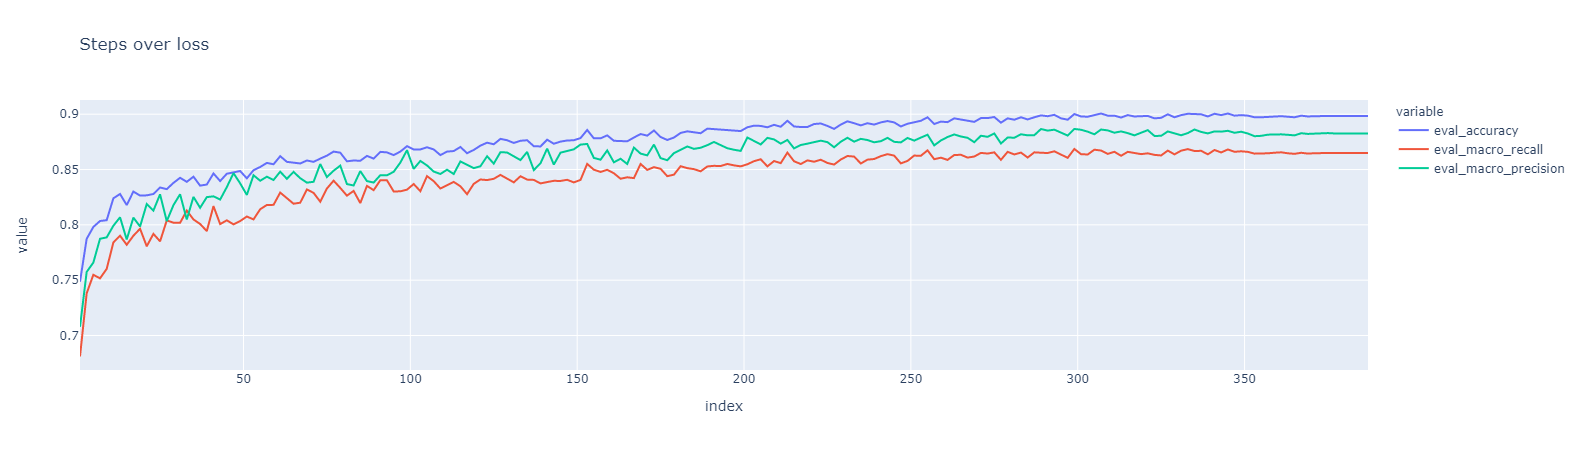

In [75]:
eval_accuracy.plot(backend="plotly", title="Steps over loss")
# fig.add_trace(next(fig.add_trace[].plot(backend="plotly").select_traces(0)))

# Hyperparameter search

In [ ]:
def hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 2e-5, 7e-5, step=1e-5),
        "warmup_steps": trial.suggest_int("warmup_steps",0,total_steps*0.1,step=total_steps*0.1*0.5),
        "gradient_accumulation_steps" : trail.suggest_int("gradient_accumulation_steps" , 1 , 10)
    }

search_space = {
        "learning_rate": trial.suggest_float("learning_rate", 2e-5, 7e-5, step=1e-5),
        "warmup_steps": trial.suggest_int("warmup_steps",0,total_steps*0.1,step=total_steps*0.1*0.5),
        "gradient_accumulation_steps" : trail.suggest_int("gradient_accumulation_steps" , 1 , 10)
}

def compute_objective(metrics):
    return metrics['eval_accuracy'] # or try "accuracy" if didn't work

In [ ]:
hyper_model = trainer.hyperparameter_search(direction="maximize",
                                         hp_space=hp_space,
                                         compute_objective=my_objective,
                                         n_trials=None,
                                         pruner=optuna.pruners.NopPruner(),
                                         sampler=optuna.samplers.GridSampler(search_space),
                                         )

In [ ]:
#trainer.hyperparameter_search(n_trials=100)

# Tensorboard

In [ ]:
# class ModelWrapper(torch.nn.Module):
#     def __init__(self, model: torch.nn.Module):
#         super().__init__()
#         self.model = model

#     def forward(self, input_x: torch.Tensor):
#         data = self.model(input_x)

#         if isinstance(data, dict):
#             data_named_tuple = namedtuple("ModelEndpoints", sorted(data.keys())) 
#             data = data_named_tuple(**data)

#         elif isinstance(data, list):
#             data = tuple(data)

#         return data
    
# writer = SummaryWriter()
# _, tensorboard = train_test_split(validate, test_size=100, random_state=1)
# costume_data = validate_dataset.X["input_ids"][:100].cuda()